### Reducción del dataset Iris - trabajamos con Merge trees

In [53]:
from lore_sa.dataset import TabularDataset
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from lore_sa.bbox import sklearn_classifier_bbox

from sklearn.metrics import classification_report, accuracy_score

from lore_sa.lore import TabularRandomGeneratorLore
from lore_sa.lore import TabularGeneticGeneratorLore

from lore_sa.encoder_decoder import ColumnTransformerEnc

from lore_sa.neighgen import RandomGenerator
from lore_sa.neighgen import GeneticGenerator

from lore_sa.surrogate import DecisionTreeSurrogate



In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lore_sa.dataset import TabularDataset
import numpy as np

# Cargar el dataset original
df = pd.read_csv('test/resources/iris.csv')

# Convertir la columna target a nombres de clases
species_mapping = {0: "setosa", 1: "versicolor", 2: "virginica"}
df["target"] = df["target"].map(species_mapping)

# Reducir el dataset manteniendo balance de clases
df_small = df.groupby("target").apply(lambda x: x.sample(n=6, random_state=42)).reset_index(drop=True)

# Guardar el nuevo dataset reducido
df_small.to_csv('test/resources/iris_small.csv', index=False)

# Cargarlo en TabularDataset

# Iris_categorical --> 150 rows
# Iris_small --> less rows

dataset_small = TabularDataset.from_csv('test/resources/iris_categorical.csv', class_name="target")

feature_names = list(dataset_small.descriptor["numeric"].keys()) + list(dataset_small.descriptor["categorical"].keys())
class_names = dataset_small.df["target"].unique().tolist()

print(dataset_small.descriptor.keys())


dataset_small.df



2025-03-28 10:23:26,734 root         INFO     test/resources/iris_categorical.csv file imported


dict_keys(['numeric', 'categorical', 'ordinal', 'target'])


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [55]:
dataset_small.df.value_counts("target")

target
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [56]:
def train_model(dataset: TabularDataset):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), [0,1,2,3]),
            ('cat', OrdinalEncoder(), [])
        ]
    )
    model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3, random_state=42))
    
    X_train, X_test, y_train, y_test = train_test_split(dataset.df.loc[:, 'sepal length (cm)':'petal width (cm)'].values, dataset.df['target'].values,
                test_size=0.3, random_state=42, stratify=dataset.df['target'].values)
    

    model.fit(X_train, y_train)

    
    return sklearn_classifier_bbox.sklearnBBox(model), X_train, y_train, X_test, y_test

### Generación de explicaciones en el dataset reducido

In [57]:
from sklearn.metrics import classification_report, accuracy_score
from lore_sa.lore import TabularRandomGeneratorLore

# Entrenar el modelo en el dataset reducido
bbox_small, X_train, y_train, X_test, y_test = train_model(dataset_small)

# Obtener predicciones en el conjunto de prueba
y_pred = bbox_small.bbox.predict(X_test)

# Imprimir métricas
print("🔍 Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))
print(f" Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

🔍 Reporte de clasificación:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

 Precisión del modelo: 0.98


Generamos los vecinos con el algoritmo genético

In [ ]:
# Crear LORE
tabularLore_small = TabularGeneticGeneratorLore(bbox_small, dataset_small) # El Genetic Generator funciona mucho mejor que el Random Generator

# Elegir una instancia para explicar
num_row = 5  # Puedes cambiar el índice para probar distintas instancias
x = dataset_small.df.iloc[num_row][:-1]

# Generar explicación
explanation_small = tabularLore_small.explain(x)

gen	nevals	avg     	min     	max     	std        
0  	500   	0.993307	0.993307	0.993307	1.11022e-16
1  	314   	0.974821	0.434774	0.993307	0.095272   
2  	309   	0.976292	0.471098	0.993307	0.0903284  
3  	297   	0.975006	0.468725	0.993307	0.0943681  
4  	316   	0.978949	0.457306	0.993307	0.0841563  
5  	300   	0.97917 	0.470383	0.993307	0.083019   
6  	298   	0.981067	0.437926	0.993307	0.0774712  
7  	310   	0.972021	0.457599	0.993307	0.101315   
8  	299   	0.972995	0.446849	0.993307	0.0992426  
9  	303   	0.977995	0.466175	0.993307	0.0866315  
10 	305   	0.977082	0.470337	0.993307	0.0887965  
11 	302   	0.98412 	0.466337	0.993307	0.0673479  
12 	316   	0.971921	0.461758	0.993307	0.101768   
13 	294   	0.981954	0.462703	0.993307	0.0751837  
14 	306   	0.969029	0.457772	0.993307	0.107766   
15 	308   	0.973045	0.453013	0.993307	0.0990046  
16 	305   	0.976998	0.460516	0.993307	0.0893369  
17 	304   	0.977046	0.465817	0.993307	0.0891958  
18 	294   	0.980139	0.456922	0.993307	0.0801648  


In [59]:
from graphviz import Digraph
from IPython.display import Image

from lore_sa.surrogate.decision_tree import EnsembleDecisionTreeSurrogate, SuperTree


# Función para visualizar el supertree
def visualize_supertree(tree, feature_names=None, class_names=None):
    dot = Digraph()
    node_id = [0]

    def add_node(node, parent_id=None, edge_label=''):
        curr_id = str(node_id[0])
        node_id[0] += 1

        if node.is_leaf:
            class_index = np.argmax(node.labels)
            class_label = class_names[class_index] if class_names else f"class {class_index}"
            label = f"class: {class_label}\n{node.labels}"
        else:
            fname = f"X_{node.feat}" if feature_names is None else feature_names[node.feat]
            label = f"{fname}"

        dot.node(curr_id, label)

        if parent_id is not None:
            dot.edge(parent_id, curr_id, label=edge_label)

        if not node.is_leaf:
            for i, child in enumerate(node.children):
                if i == 0:
                    label = f"<= {node.intervals[i]:.2f}"
                else:
                    label = f"> {node.intervals[i - 1]:.2f}"
                add_node(child, curr_id, label)

    add_node(tree)
    return dot

#### Árboles inciales antes de la mezcla

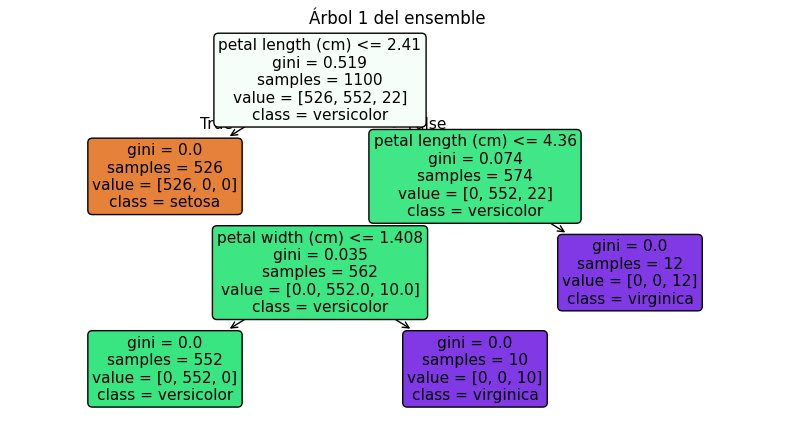

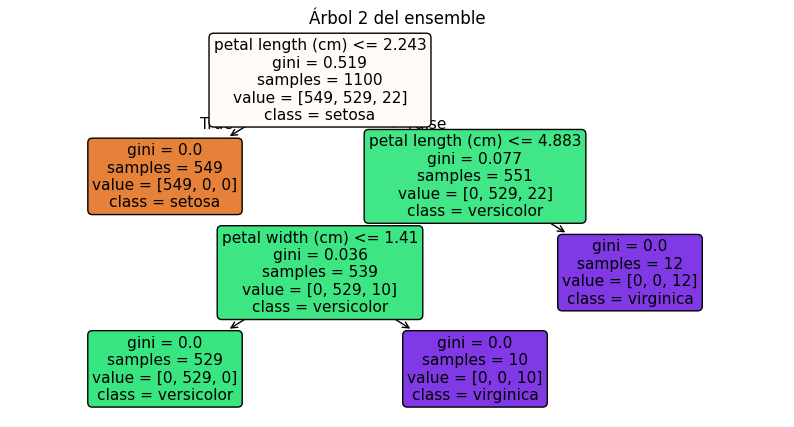

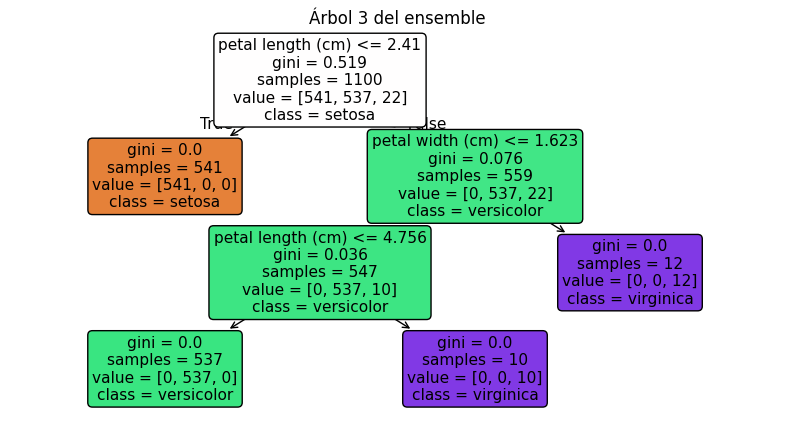

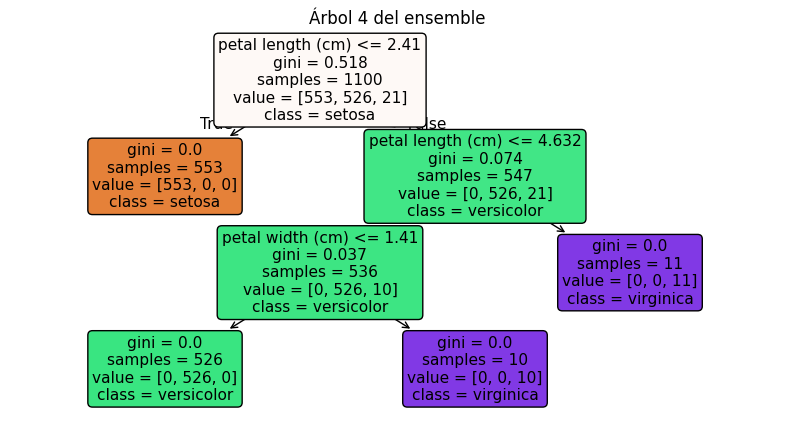

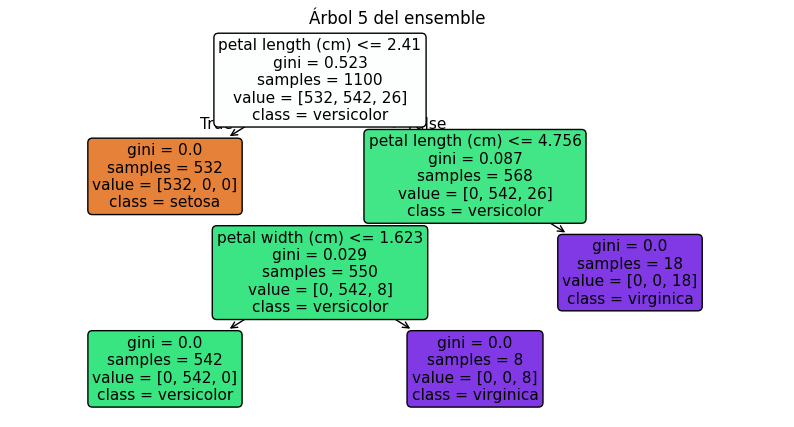

In [60]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

ensemble = tabularLore_small.surrogate  # ya está entrenado internamente

# Dibujar cada árbol individual
for i, tree in enumerate(ensemble.trees):
    plt.figure(figsize=(10, 5))
    plot_tree(tree, filled=True, rounded=True, 
              feature_names=feature_names, 
              class_names=class_names)
    plt.title(f"Árbol {i+1} del ensemble")
    plt.show()

#### Supertree sin podar

2025-03-28 10:23:56,306 graphviz.saving DEBUG    write lines to 'supertree_unpruned'
2025-03-28 10:23:56,308 graphviz.backend.execute DEBUG    run [WindowsPath('dot'), '-Kdot', '-Tpng', '-O', 'supertree_unpruned']
2025-03-28 10:23:56,534 graphviz.rendering DEBUG    delete 'supertree_unpruned'


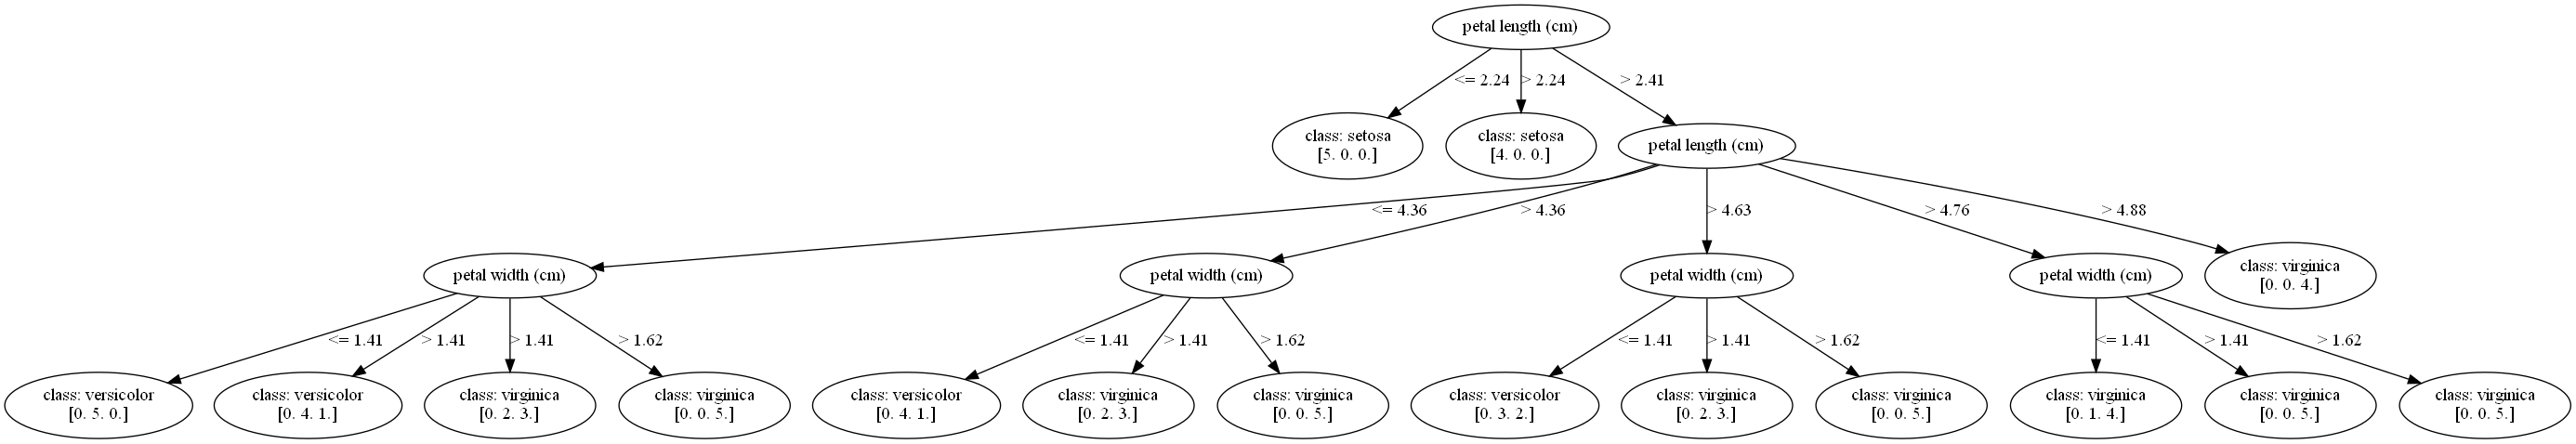

In [61]:
# Guardar también el árbol sin podar
ensemble = tabularLore_small.surrogate  # ya está entrenado internamente
unpruned_tree = SuperTree()
roots = [unpruned_tree.rec_buildTree(tree, list(range(tree.n_features_in_))) for tree in ensemble.trees]
unpruned_tree.mergeDecisionTrees(roots, num_classes=ensemble.trees[0].n_classes_)

# Guardar dentro de explanation_small
explanation_small["unpruned_tree"] = unpruned_tree

visualize_supertree(
    explanation_small["unpruned_tree"].root,
    feature_names=feature_names,
    class_names=class_names
).render('supertree_unpruned', format='png', cleanup=True)

Image(filename='supertree_unpruned.png')


#### SuperTree con la poda

2025-03-28 10:23:56,568 graphviz.saving DEBUG    write lines to 'supertree'
2025-03-28 10:23:56,568 graphviz.backend.execute DEBUG    run [WindowsPath('dot'), '-Kdot', '-Tpng', '-O', 'supertree']
2025-03-28 10:23:56,676 graphviz.rendering DEBUG    delete 'supertree'


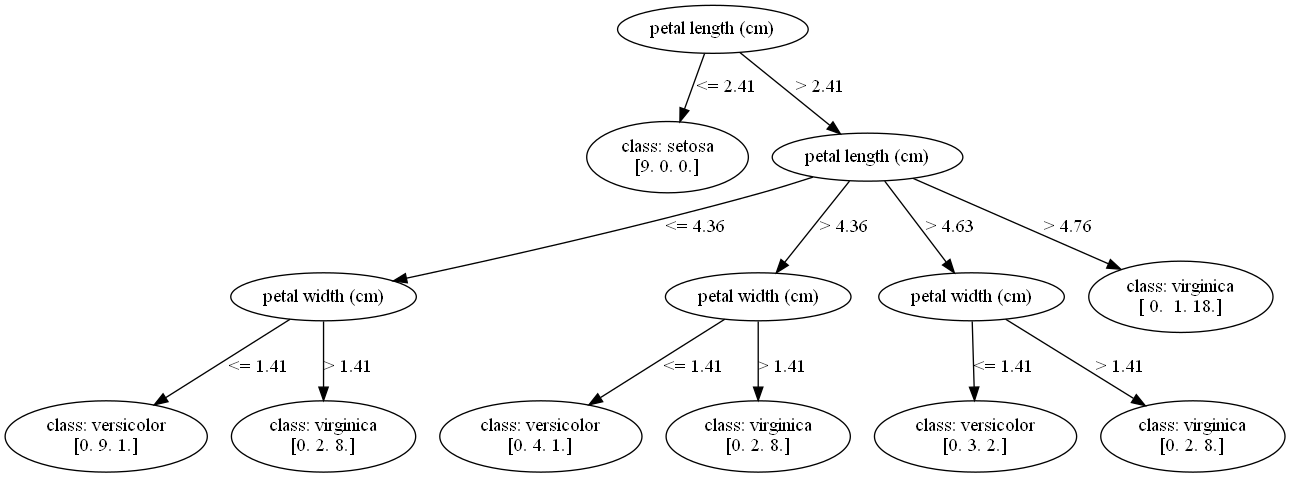

In [62]:
# Generar el supertree y visualizarlo
merged = explanation_small["merged_tree"]
visualize_supertree(merged.root, feature_names=feature_names, class_names=class_names).render('supertree', format='png', cleanup=True)

# Mostrar la imagen renderizada
Image(filename='supertree.png')

In [63]:
x = dataset_small.df.iloc[num_row][:-1]
print(x)

y = dataset_small.df.iloc[num_row][-1]
print(y)

sepal length (cm)    5.4
sepal width (cm)     3.9
petal length (cm)    1.7
petal width (cm)     0.4
Name: 5, dtype: object
setosa


Comprobamos que se cumplen las reglas para la instancia que queremos explicar.

In [64]:
def check_rule_validity_v2(X, y, explanation, dataset_name="Train", decimals=1):
    """
    Comprueba cuántas instancias cumplen la regla generada por LORE,
    mostrando la regla principal antes de la evaluación.
    """
    rule = explanation['rule']
    conditions = rule['premises']
    target_class = rule['consequence']['val']

    print(f"\n{'='*70}")
    print(f"✅ Condiciones necesarias para que la flor sea clasificada como '{target_class}':")
    for cond in conditions:
        attr, op, val = cond['attr'], cond['op'], round(cond['val'], decimals)
        print(f"  - {attr} {op} {val}")

    print(f"\n{'='*70}")
    print(f"✅ Comprobando regla para la clase '{target_class}' en el {dataset_name}...")
    print(f"{'='*70}")

    valid_instances = []
    incorrect_classifications = 0  

    indices_clase_objetivo = [i for i in range(len(y)) if y[i] == target_class]

    if not indices_clase_objetivo:
        print(f"🚫 No hay instancias de la clase '{target_class}' en {dataset_name}.")
        return  # No hay instancias de esta clase, terminamos la función.

    for i in indices_clase_objetivo:
        cumple_todas = True
        print(f"\n🔎 Instancia {i}: {X[i]} - Clase real: {y[i]}")

        for cond in conditions:
            attr, op, val = cond['attr'], cond['op'], round(cond['val'], decimals)
            col_index = list(dataset_small.df.columns).index(attr)
            instancia_val = round(X[i, col_index], decimals)

            if op == ">":
                cumple = instancia_val > val
            elif op == "<":
                cumple = instancia_val < val
            elif op == ">=":
                cumple = instancia_val >= val
            elif op == "<=":
                cumple = instancia_val <= val
            elif op == "!=":
                cumple = instancia_val != val
            elif op == "=":
                cumple = instancia_val == val

            print(f"   - {attr} {op} {val} → Valor en la instancia: {instancia_val} {'✅' if cumple else '❌'}")
            cumple_todas &= cumple

        if cumple_todas:
            valid_instances.append(i)
        else:
            incorrect_classifications += 1

    # Resultados finales
    print(f"\n🔍 {len(valid_instances)} de {len(indices_clase_objetivo)} instancias de '{target_class}' cumplen la regla completamente.")
    print(f"✅ {len(valid_instances)} realmente son '{target_class}'.")
    print(f"❌ {incorrect_classifications} fueron clasificadas incorrectamente.")
    print(f"{'='*70}")

# 📌 Validar la regla en entrenamiento y test
check_rule_validity_v2(X_train, y_train, explanation_small, dataset_name="Train")
check_rule_validity_v2(X_test, y_test, explanation_small, dataset_name="Test")



✅ Condiciones necesarias para que la flor sea clasificada como 'setosa':
  - petal length (cm) <= 2.4

✅ Comprobando regla para la clase 'setosa' en el Train...

🔎 Instancia 2: [5.1 3.8 1.5 0.3] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.5 ✅

🔎 Instancia 6: [4.9 3.1 1.5 0.1] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.5 ✅

🔎 Instancia 7: [5.1 3.8 1.6 0.2] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.6 ✅

🔎 Instancia 8: [4.4 2.9 1.4 0.2] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.4 ✅

🔎 Instancia 11: [4.9 3.  1.4 0.2] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.4 ✅

🔎 Instancia 12: [5.  3.  1.6 0.2] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.6 ✅

🔎 Instancia 16: [5.  3.4 1.6 0.4] - Clase real: setosa
   - petal length (cm) <= 2.4 → Valor en la instancia: 1.6 ✅

🔎 Instancia 17: [4.7 3

In [52]:
def check_counterfactuals(X, y, explanation, dataset_name="Train", decimals=1):
    """
    Evalúa los contrafactuales en un dataset (Train/Test) para verificar cuántas instancias reales cumplen sus condiciones.
    """
    counterfactuals = explanation['counterfactuals']

    print(f"\n{'='*70}")
    print(f"🔄 Comprobando CONTRAFACTUALES en el dataset {dataset_name}...")
    # print(f"{'='*70}")

    for idx, cf in enumerate(counterfactuals, start=1):
        conditions = cf['premises']
        target_class = cf['consequence']['val']

        print(f"\n🛑 CASO {idx}: Si se cumplen estas condiciones, la flor sería clasificada como '{target_class}'")
        for cond in conditions:
            attr, op, val = cond['attr'], cond['op'], round(cond['val'], decimals)
            print(f"  - {attr} {op} {val}")

        print("\n🔎 Evaluando instancias en el dataset...")
        valid_instances = []
        incorrect_classifications = 0

        # Filtrar solo las instancias que ya son de la clase objetivo del contrafactual
        indices_clase_objetivo = [i for i in range(len(y)) if y[i] == target_class]

        if not indices_clase_objetivo:
            print(f"🚫 No hay instancias de la clase '{target_class}' en {dataset_name}.")
            continue

        for i in indices_clase_objetivo:
            cumple_todas = True
            print(f"\n Instancia {i}: {X[i]} - Clase real: {y[i]}")

            for cond in conditions:
                attr, op, val = cond['attr'], cond['op'], round(cond['val'], decimals)
                col_index = list(dataset_small.df.columns).index(attr)
                instancia_val = round(X[i, col_index], decimals)

                if op == ">":
                    cumple = instancia_val > val
                elif op == "<":
                    cumple = instancia_val < val
                elif op == ">=":
                    cumple = instancia_val >= val
                elif op == "<=":
                    cumple = instancia_val <= val
                elif op == "!=":
                    cumple = instancia_val != val
                elif op == "=":
                    cumple = instancia_val == val

                print(f"   - {attr} {op} {val} → Valor en la instancia: {instancia_val} {'✅' if cumple else '❌'}")
                cumple_todas &= cumple

            if cumple_todas:
                valid_instances.append(i)
            else:
                incorrect_classifications += 1

        # Resultados finales del contrafactual
        print(f"\n✅ {len(valid_instances)} de {len(indices_clase_objetivo)} instancias de '{target_class}' cumplen el contrafactual completamente.")
        # print(f" {len(valid_instances)} realmente son '{target_class}'.")
        print(f"❌ {incorrect_classifications} fueron clasificadas incorrectamente.")
        print(f"{'='*70}")

# 📌 Evaluar contrafactuales en Train y Test
check_counterfactuals(X_train, y_train, explanation_small, dataset_name="Train")
check_counterfactuals(X_test, y_test, explanation_small, dataset_name="Test")



🔄 Comprobando CONTRAFACTUALES en el dataset Train...

🛑 CASO 1: Si se cumplen estas condiciones, la flor sería clasificada como 'versicolor'
  - petal length (cm) <= 5.1
  - petal length (cm) > 2.4
  - petal width (cm) <= 1.7

🔎 Evaluando instancias en el dataset...

 Instancia 0: [5.1 2.5 3.  1.1] - Clase real: versicolor
   - petal length (cm) <= 5.1 → Valor en la instancia: 3.0 ✅
   - petal length (cm) > 2.4 → Valor en la instancia: 3.0 ✅
   - petal width (cm) <= 1.7 → Valor en la instancia: 1.1 ✅

 Instancia 1: [6.2 2.2 4.5 1.5] - Clase real: versicolor
   - petal length (cm) <= 5.1 → Valor en la instancia: 4.5 ✅
   - petal length (cm) > 2.4 → Valor en la instancia: 4.5 ✅
   - petal width (cm) <= 1.7 → Valor en la instancia: 1.5 ✅

 Instancia 4: [5.7 2.8 4.1 1.3] - Clase real: versicolor
   - petal length (cm) <= 5.1 → Valor en la instancia: 4.1 ✅
   - petal length (cm) > 2.4 → Valor en la instancia: 4.1 ✅
   - petal width (cm) <= 1.7 → Valor en la instancia: 1.3 ✅

 Instancia 13:

Evaluamos la estabilidad

In [15]:
from collections import defaultdict

explanations = defaultdict(list)

from collections import defaultdict

def check_stability(tabularLore_small, dataset_small, num_instances, decimals=1):
    """
    Evalúa la estabilidad de LORE generando explicaciones para diferentes instancias de la misma clase y comparando reglas.
    """
    explanations = defaultdict(list)
    
    # Obtener la clase de la primera instancia para comparar dentro de la misma clase
    target_class = dataset_small.df.iloc[0, -1]
    
    # Filtrar solo las instancias de esa clase
    same_class_indices = dataset_small.df[dataset_small.df.iloc[:, -1] == target_class].index[:num_instances]

    for i in same_class_indices:
        x = dataset_small.df.iloc[i, :-1].values  # Seleccionar correctamente la instancia

        explanation = tabularLore_small.explain(x)

        # Extraer la regla principal
        rule_conditions = tuple(sorted(
            (cond['attr'], cond['op'], round(cond['val'], decimals) if isinstance(cond['val'], (int, float)) else cond['val'])
            for cond in explanation['rule']['premises']
        ))
        explanations[rule_conditions].append(i)

    print("\n🔍 **Evaluación de Estabilidad:**")
    print(f"Generando explicaciones para {len(same_class_indices)} instancias de la clase '{target_class}'...\n")

    for rule, indices in explanations.items():
        print(f"💡 Regla encontrada en instancias: {indices}")
        print(f"   → {rule}\n")

    # Medir estabilidad como el número de reglas únicas encontradas
    stability_score = len(explanations) / len(same_class_indices)
    print(f"📊 **Estabilidad LORE:** {1 - stability_score:.2f} (1=Totalmente estable, 0=Inestable)")

# 📌 Ejecutar test de estabilidad en el dataset reducido
check_stability(tabularLore_small, dataset_small, num_instances=10, decimals=1)


gen	nevals	avg     	min     	max     	std        
0  	500   	0.993307	0.993307	0.993307	1.11022e-16
1  	308   	0.979852	0.447562	0.993307	0.0818921  
2  	287   	0.978957	0.431862	0.993307	0.0842626  
3  	304   	0.982024	0.447797	0.993307	0.0746282  
4  	294   	0.980221	0.459079	0.993307	0.0798161  
5  	288   	0.975754	0.40341 	0.993307	0.0933438  
6  	324   	0.981074	0.463591	0.993307	0.0775059  
7  	296   	0.975627	0.380728	0.993307	0.0941632  
8  	308   	0.979039	0.456818	0.993307	0.0837548  
9  	301   	0.980941	0.44598 	0.993307	0.0783521  
10 	277   	0.979923	0.447772	0.993307	0.0815123  
11 	309   	0.975822	0.44971 	0.993307	0.0928281  
12 	298   	0.981016	0.446084	0.993307	0.0777039  
13 	298   	0.983109	0.472558	0.993307	0.0705777  
14 	326   	0.977158	0.470906	0.993307	0.0884519  
15 	313   	0.975024	0.463506	0.993307	0.0940795  
16 	308   	0.972958	0.456113	0.993307	0.0994826  
17 	322   	0.978768	0.389956	0.993307	0.0851498  
18 	274   	0.979122	0.456063	0.993307	0.0831787  


Comprobamos si es accionable

 No se puede porque según tengo entendido, la accionabilidad tiene sentido si esos cambios representan una acción realista en la vida real, en Iris modificar el sepal length (por ejemplo) no es una acción que la flor pueda "decidir". 